In [117]:
import warnings
warnings. filterwarnings("ignore")

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math 
import shutil
import glob

In [119]:
#count the number of images 


Root_dir = "Z_TransferDataSet"
number_of_images = {}

for dir in os.listdir(Root_dir):
  number_of_images[dir] = len(os.listdir(os.path.join(Root_dir,dir)))

In [120]:
number_of_images.items()

dict_items([('Brain Tumor', 8), ('Healthy', 7)])

In [121]:
def datafolder(path,split):
    
    # Create the train_folder if it doesn't exist
    if not os.path.exists("./"+path):
        os.makedirs("./"+path)
        
        for dir in os.listdir(Root_dir):
            dir_path = os.path.join(Root_dir, dir)
            if os.path.isdir(dir_path):  # Ensure it's a directory
                os.makedirs(os.path.join("./"+path+"/", dir))

                # Select random images to copy
                selected_images = np.random.choice(
                    a=os.listdir(dir_path),
                    size=math.floor(split * number_of_images.get(dir, 0) - 2), 
                    replace=False
                )
                
                for img in selected_images:
                    src = os.path.join(dir_path, img)  # Correct path to the image
                    dst = os.path.join("./"+path, dir, img)  # Destination path for the image
                    
                    shutil.copy(src, dst)  # Copy the image
                    os.remove(src)  # Remove the image from the original folder

    else:
        print("Folder exists")
       



In [122]:
datafolder("Z_train_folder",0.7)

Folder exists


In [123]:
datafolder("Z_test_folder",0.15)

Folder exists


In [124]:
datafolder("Z_val_folder",0.15)

Folder exists


In [125]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.mobilenet import preprocess_input

In [126]:
def preprocessingImages(path):
    image_data=ImageDataGenerator(zoom_range= 0.2,
                                  shear_range=0.2,
                                  preprocessing_function= preprocess_input,
                                  horizontal_flip=True)
    image=image_data.flow_from_directory(directory=path,
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode='binary')
    return image

In [127]:
Z_train_data=preprocessingImages("Z_train_folder")

Found 3215 images belonging to 2 classes.


In [128]:
def preprocessingImages2(path):
    image_data=ImageDataGenerator(preprocessing_function= preprocess_input)
    image=image_data.flow_from_directory(directory=path,
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode='binary')
    return image

In [129]:
Z_test_data=preprocessingImages2("Z_test_folder")

Found 685 images belonging to 2 classes.


In [130]:
Z_val_data=preprocessingImages2("Z_val_folder")

Found 685 images belonging to 2 classes.


Model Training

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import keras as keras
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet, preprocess_input

In [132]:
base_model=MobileNet(input_shape=(224,224,3),include_top=False)

In [133]:
for layer in base_model.layers:
    layer.trainable=False

In [134]:
base_model.summary

<bound method Model.summary of <Functional name=mobilenet_1.00_224, built=True>>

In [135]:
X= Flatten()(base_model.output)
X=Dense(units=1,activation='sigmoid')(X)

model=Model(base_model.input, X)

In [136]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,279,041 (12.51 MB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [137]:
model.compile(optimizer='rmsprop',loss= keras.losses.binary_crossentropy,metrics=['accuracy'])

In [138]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [139]:
model_checkpoint= ModelCheckpoint(filepath="bestmodel.keras",
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True)

early_stopping= EarlyStopping(monitor='val_accuracy', 
                              min_delta=0.01,
                              patience=3,
                              verbose=1)
Call_backs=[model_checkpoint, early_stopping]

In [140]:
from tensorflow.keras.callbacks import Callback

In [141]:
history=model.fit(Z_train_data,
                  steps_per_epoch=10,
                  epochs=10,
                  validation_data=Z_val_data,
                  validation_steps=16,
                  callbacks=Call_backs
                  )

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.5963 - loss: 9.4920
Epoch 1: val_accuracy improved from -inf to 0.83789, saving model to bestmodel.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6032 - loss: 9.2408 - val_accuracy: 0.8379 - val_loss: 1.4848
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7279 - loss: 2.2950
Epoch 2: val_accuracy improved from 0.83789 to 0.83815, saving model to bestmodel.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 820ms/step - accuracy: 0.7308 - loss: 2.2581 - val_accuracy: 0.8382 - val_loss: 0.9418
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8094 - loss: 1.4272
Epoch 3: val_accuracy improved from 0.83815 to 0.86719, saving model to bestmodel.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8083 - loss: 1.4546 - val_accuracy: 0.8672 - val_loss: 1.1017
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.8990 - loss: 0.6293
Epoch 4: val_accuracy did not improve from 0.867

In [142]:
model=load_model('bestmodel.keras')

In [143]:
accuracy=model.evaluate(Z_test_data)[1]
print(f" Our model accuracy is {accuracy*100} %")

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.9479 - loss: 0.2526
 Our model accuracy is 93.86861324310303 %


In [144]:
h=history.history
h.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

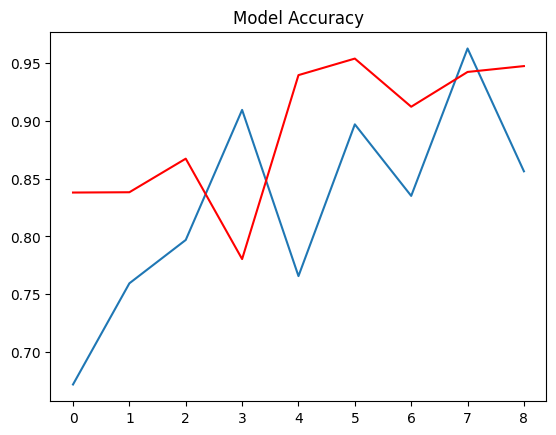

In [145]:
plt.plot(h['accuracy'])

plt.plot(h['val_accuracy'], c='red')

plt.title('Model Accuracy')

plt.show()

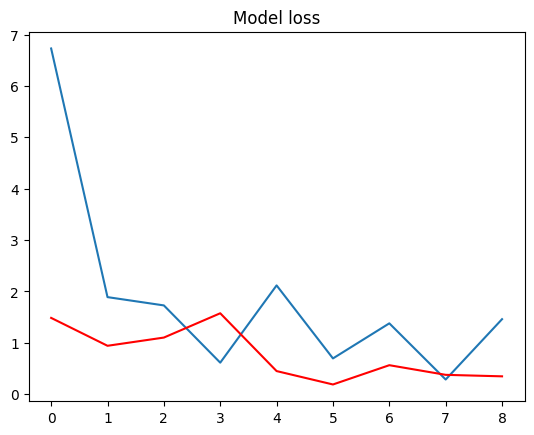

In [146]:
plt.plot(h['loss'])

plt.plot(h['val_loss'], c='red')

plt.title('Model loss')

plt.show()

In [147]:
from tensorflow.keras.utils import load_img, img_to_array

def check_tumor(path):
    img = load_img(path, target_size=(224, 224))
    input_arr = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]

    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Expand dimensions to add batch size
    input_arr = np.expand_dims(input_arr, axis=0)

    # Predict the probability of the tumor
    pred_prob = model.predict(input_arr)[0][0]  # Single value from sigmoid

    if pred_prob >= 0.5:
        print(f"The image is healthy .")
    else:
        print(f"The image contains tumor .")


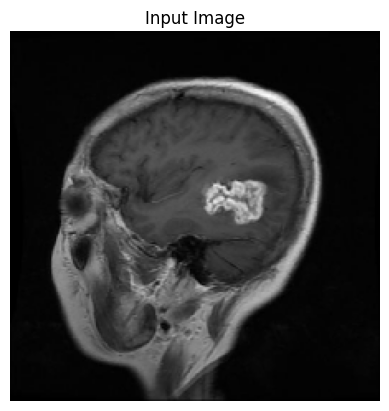

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
The image contains tumor .


In [148]:
check_tumor("Z_TransferDataSet\Brain Tumor\Cancer (258).jpg")

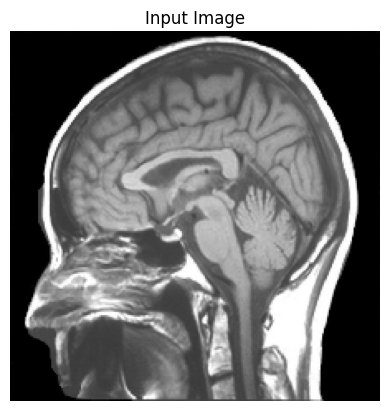

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The image is healthy .


In [149]:
check_tumor(r"Z_TransferDataSet\Healthy\Not Cancer  (346).jpg")

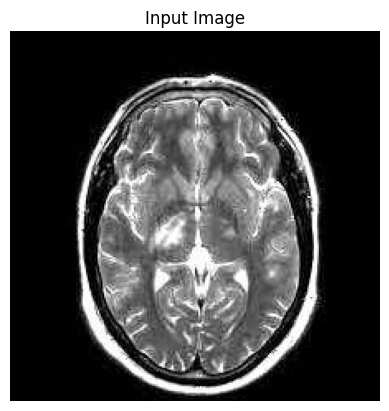

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
The image is healthy .


In [150]:
check_tumor(r"Z_TransferDataSet\Healthy\Not Cancer  (1181).jpg")

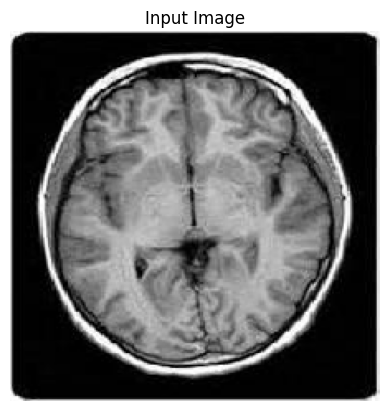

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
The image is healthy .


In [151]:
check_tumor(r"Z_TransferDataSet\Healthy\Not Cancer  (1601).jpg")

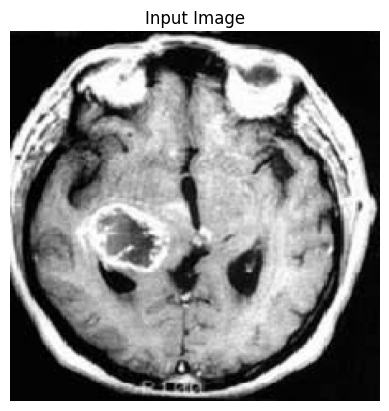

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
The image contains tumor .


In [152]:
check_tumor(r"Z_TransferDataSet\Brain Tumor\Cancer (849).jpg")

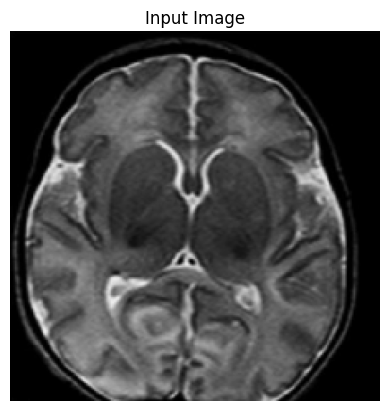

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
The image is healthy .


In [153]:
check_tumor("Brain Tumor Data Set/Healthy/Not Cancer  (188).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


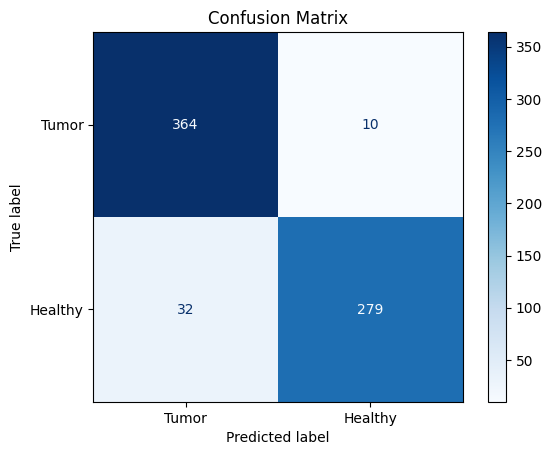

Classification Report:
              precision    recall  f1-score   support

       Tumor       0.92      0.97      0.95       374
     Healthy       0.97      0.90      0.93       311

    accuracy                           0.94       685
   macro avg       0.94      0.94      0.94       685
weighted avg       0.94      0.94      0.94       685



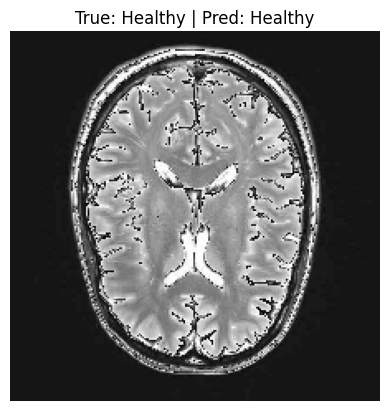

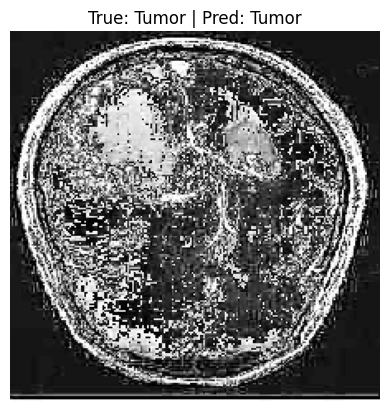

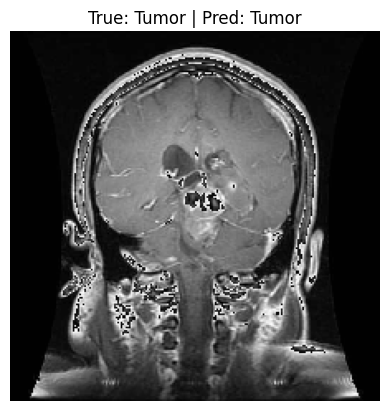

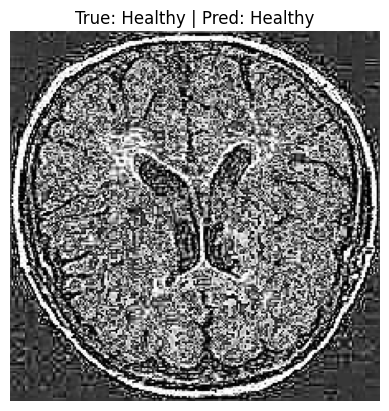

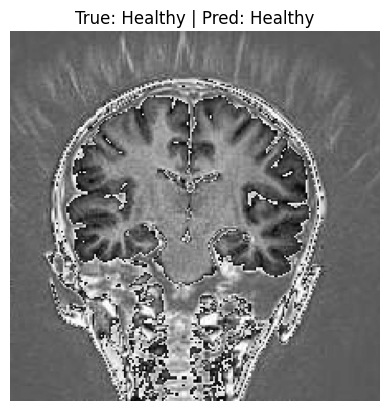

In [154]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import random
from tensorflow.keras.utils import load_img, img_to_array

# Step 1: Get True Labels and Predictions
true_labels = []
predictions = []
images_batch = []  # Store some test images for visualization

# Iterate over the test data
for batch in Z_test_data:
    images, labels = batch
    true_labels.extend(labels)  # Add true labels
    preds = model.predict(images)  # Predict probabilities
    predictions.extend([1 if p >= 0.5 else 0 for p in preds])  # Threshold at 0.5
    images_batch.extend(images)  # Save images for visualization
    if len(true_labels) >= Z_test_data.samples:  # Stop once all samples are processed
        break

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Step 2: Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Tumor', 'Healthy'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Step 3: Classification Report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=['Tumor', 'Healthy']))

# Step 4: Random Image Visualization with Ground Truth and Predictions
def visualize_random_predictions(images_batch, true_labels, predictions, num_images=5):
    indices = random.sample(range(len(images_batch)), num_images)  # Pick random indices
    
    for idx in indices:
        image = images_batch[idx]
        true_label = 'Tumor' if true_labels[idx] == 0 else 'Healthy'
        pred_label = 'Tumor' if predictions[idx] == 0 else 'Healthy'
        
        # Denormalize the image for visualization
        image = (image * 255).astype(np.uint8)
        
        plt.imshow(image)
        plt.title(f"True: {true_label} | Pred: {pred_label}")
        plt.axis('off')
        plt.show()

# Call the function to visualize results
visualize_random_predictions(images_batch, true_labels, predictions, num_images=5)
